<a href="https://colab.research.google.com/github/fab464654/models_logs/blob/main/FCNet_vs_CNN_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#Importo le librerie necessarie
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import imageio
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torchvision
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Clone della cartella che ho creato su GitHub
#(puoi scaricare i log del training e i modelli)
!pip install -q xlrd

if os.path.isdir("models_logs/") == False: #Se non c'è già clono
  !git clone https://github.com/fab464654/models_logs.git

#Struttura della rete CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

#Struttura della rete FCNet
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512) #Input layer (immagini)
        self.fc2 = nn.Linear(512, 256)   #Hidden layer 1
        self.fc3 = nn.Linear(256, 128)   #Hidden layer 2
        self.fc4 = nn.Linear(128, 10)    #Output layer (10 classi diverse)
        self.dropout = nn.Dropout2d(0.5) #Droput

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)
        output = F.log_softmax(x, dim=1)
        return output

#Caricamento modelli precedentemente allenati
model_CNN_MNIST = CNN()
state_dict_1 = torch.load('models_logs/MNIST_CNN.pth')
model_CNN_MNIST.load_state_dict(state_dict_1)
model_CNN_MNIST = model_CNN_MNIST.to(device)
model_CNN_MNIST.eval()

model_CNN_QMNIST = CNN()
state_dict_2 = torch.load('models_logs/QMNIST_CNN.pth')
model_CNN_QMNIST.load_state_dict(state_dict_2)
model_CNN_QMNIST = model_CNN_QMNIST.to(device)
model_CNN_QMNIST.eval()

model_FCNet_MNIST = FCNet()
state_dict_3 = torch.load('models_logs/MNIST_FCNet.pth')
model_FCNet_MNIST.load_state_dict(state_dict_3)
model_FCNet_MNIST = model_FCNet_MNIST.to(device)
model_FCNet_MNIST.eval()

model_FCNet_QMNIST = FCNet()
state_dict_4 = torch.load('models_logs/QMNIST_FCNet.pth')
model_FCNet_QMNIST.load_state_dict(state_dict_4)
model_FCNet_QMNIST = model_FCNet_QMNIST.to(device)
model_FCNet_QMNIST.eval()

print("Modelli caricati con successo")


Modelli caricati con successo


Per avere un quadro generale delle performance di ciascun modello su ciascun dataset (8 combinazioni) è possibile stampare l'accuratezza tramite la procedura di test (effettuata su tutto il dataset di testing, non solo le 5 immagini selezionate)

In [18]:
#Download dei dataset su cui testare i modelli
mnist_test = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download =True)
Qmnist_test = datasets.QMNIST(root="./data", what ='test', train=False, transform=transforms.ToTensor(), download =True)

#Nel testing la batch_size non influisce sulle performance ma solo sul tempo impiegato
dataset_test_MNIST = DataLoader(mnist_test, batch_size=1000, shuffle=True)
dataset_test_QMNIST = DataLoader(Qmnist_test, batch_size=1000, shuffle=True)

def testComplete(model, device, test_loader, modelName):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad(): #Non vogliamo ricalcolare il gradiente (pesi)
      for data, target in test_loader:
          data = data.to(device)
          target = target.to(device)
          output = model(data)

          #Sommatoria della test_loss per ogni immagine
          test_loss += F.nll_loss(output, target, reduction='sum').item()
          
          #Estraggo la classe di appartenenza più probabile
          pred = output.argmax(dim=1, keepdim=True) 
          
          #Tengo conto delle corrispondenze esatte
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('Risultati del '+modelName+': Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
    
testComplete(model_CNN_MNIST, device, dataset_test_MNIST, "modello CNN allenato sul MNIST, testato sul MNIST")
testComplete(model_CNN_MNIST, device, dataset_test_QMNIST, "modello CNN allenato sul MNIST, testato sul QMNIST")
print('\n')
testComplete(model_CNN_QMNIST, device, dataset_test_MNIST, "modello CNN allenato sul QMNIST, testato sul MNIST")
testComplete(model_CNN_QMNIST, device, dataset_test_QMNIST, "modello CNN allenato sul QMNIST, testato sul QMNIST")
print('\n')
testComplete(model_FCNet_MNIST, device, dataset_test_MNIST, "modello FCNet allenato sul MNIST, testato sul MNIST")
testComplete(model_FCNet_MNIST, device, dataset_test_QMNIST, "modello FCNet allenato sul MNIST, testato sul QMNIST")
print('\n')
testComplete(model_FCNet_QMNIST, device, dataset_test_MNIST, "modello FCNet allenato sul QMNIST, testato sul MNIST")
testComplete(model_FCNet_QMNIST, device, dataset_test_QMNIST, "modello FCNet allenato sul QMNIST, testato sul QMNIST")

Risultati del modello CNN allenato sul MNIST, testato sul MNIST: Average loss: 0.0378, Accuracy: 9894/10000 (99%)
Risultati del modello CNN allenato sul MNIST, testato sul QMNIST: Average loss: 0.0464, Accuracy: 59295/60000 (99%)


Risultati del modello CNN allenato sul QMNIST, testato sul MNIST: Average loss: 0.0381, Accuracy: 9894/10000 (99%)
Risultati del modello CNN allenato sul QMNIST, testato sul QMNIST: Average loss: 0.0477, Accuracy: 59302/60000 (99%)


Risultati del modello FCNet allenato sul MNIST, testato sul MNIST: Average loss: 1.4228, Accuracy: 3964/10000 (40%)
Risultati del modello FCNet allenato sul MNIST, testato sul QMNIST: Average loss: 1.4223, Accuracy: 23973/60000 (40%)


Risultati del modello FCNet allenato sul QMNIST, testato sul MNIST: Average loss: 1.8401, Accuracy: 3049/10000 (30%)
Risultati del modello FCNet allenato sul QMNIST, testato sul QMNIST: Average loss: 1.8455, Accuracy: 18283/60000 (30%)


Di seguito si può osservare l'andamento della Loss cioè dell'errore, durante le fasi di training, per entrambi i modelli allenati sui due dataset (in totale 4 grafici). Come ci si aspetterebbe le CNN si comportano notevolmente meglio rispetto alle reti Fully Connected.

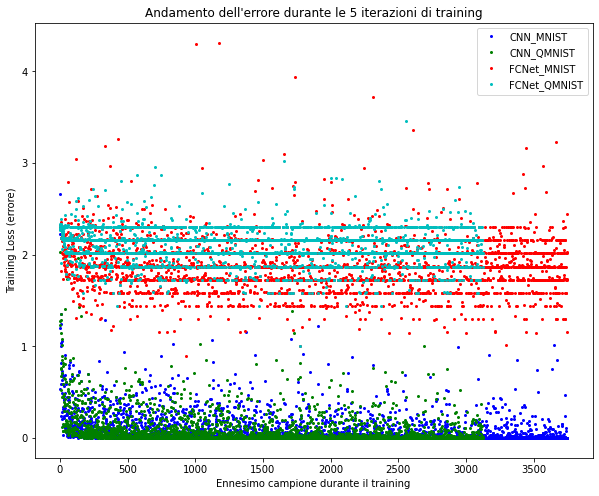

In [19]:
#Plot delle Loss durante il training per i 2 modelli sui 2 dataset
import matplotlib.pyplot as plt
import csv

#Importo i dati dai CSV ottenuti precedentemente (durante il training)
x_CNN_MNIST = []
y_CNN_MNIST = []
with open('models_logs/logCSV_MNIST_CNN.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')  
    for row in plots:
      for i in range(0,3750):
        x_CNN_MNIST.append(i)
        y_CNN_MNIST.append(float(row[i]))

x_CNN_QMNIST = []
y_CNN_QMNIST = []
with open('models_logs/logCSV_QMNIST_CNN.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')  
    for row in plots:
      for i in range(0,3125):
        x_CNN_QMNIST.append(i)
        y_CNN_QMNIST.append(float(row[i]))

x_FCNet_MNIST = []
y_FCNet_MNIST = []
with open('models_logs/logCSV_MNIST_FCNet.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')  
    for row in plots:
      for i in range(0,3750):
        x_FCNet_MNIST.append(i)
        y_FCNet_MNIST.append(float(row[i]))

x_FCNet_QMNIST = []
y_FCNet_QMNIST = []
with open('models_logs/logCSV_QMNIST_FCNet.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')  
    for row in plots:
      for i in range(0,3125):
        x_FCNet_QMNIST.append(i)
        y_FCNet_QMNIST.append(float(row[i]))

#Grafico con l'errore di training dei vari modelli
plt.figure(figsize=(10,8))
plt.plot(x_CNN_MNIST,y_CNN_MNIST,'bo',markersize=2, label='CNN_MNIST')
plt.plot(x_CNN_QMNIST,y_CNN_QMNIST,'go',markersize=2, label='CNN_QMNIST',)
plt.plot(x_FCNet_MNIST,y_FCNet_MNIST,'ro',markersize=2, label='FCNet_MNIST')
plt.plot(x_FCNet_QMNIST,y_FCNet_QMNIST,'co',markersize=2, label='FCNet_QMNIST',)


plt.ylabel('Training Loss (errore)')
plt.xlabel('Ennesimo campione durante il training')
plt.title('Andamento dell\'errore durante le 5 iterazioni di training')
plt.legend()
plt.show()

A questo punto è possibile modificare la BATCH_SIZE, ovvero il numero di immagini che vengono usate per effettuare la simulazione a video. I modelli proveranno a predire il numero scritto a mano in ciascuna fotografia.
Inoltre si può impostare il dataset da cui vengono prelevate le immagini (MNIST o QMNIST). 

Etichette (valori veri):  [2 0 5 3 6]

Modello CNN allenato sul dataset QMNIST: 
Predizione:  [2]  con probabilità  [99.99998] %
Predizione:  [0]  con probabilità  [100.] %
Predizione:  [5]  con probabilità  [100.] %
Predizione:  [3]  con probabilità  [99.99994] %
Predizione:  [6]  con probabilità  [100.] %

Modello CNN allenato sul dataset MNIST: 
Predizione:  [2]  con probabilità  [99.999954] %
Predizione:  [0]  con probabilità  [100.] %
Predizione:  [5]  con probabilità  [100.] %
Predizione:  [3]  con probabilità  [99.999985] %
Predizione:  [6]  con probabilità  [100.] %

Modello FCNet allenato sul dataset QMNIST: 
Predizione:  [0]  con probabilità  [10.] %
Predizione:  [0]  con probabilità  [10.] %
Predizione:  [0]  con probabilità  [10.] %
Predizione:  [3]  con probabilità  [71.07914] %
Predizione:  [0]  con probabilità  [10.] %

Modello FCNet allenato sul dataset MNIST:
Predizione:  [0]  con probabilità  [10.] %
Predizione:  [0]  con probabilità  [99.99968] %
Predizione:  [0]  co

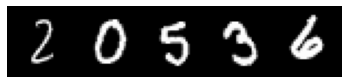

In [21]:
#Numero di immagini che vengono testate (consiglio < 10 per distinguerle)
BATCH_SIZE = 5 

#Download dei dataset su cui testare i modelli
mnist_test = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download =True)
Qmnist_test = datasets.QMNIST(root="./data", what ='test', train=False, transform=transforms.ToTensor(), download =True)

#shuffle = True in modo che cambino ad ogni esecuzione
test_loader_mnist = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)
test_loader_Qmnist = DataLoader(Qmnist_test, batch_size=BATCH_SIZE, shuffle=True)

#Funzione per mostrare le immagini
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)),)
    plt.axis('off')

#Funzione per testare i modelli sulle immagini selezionate
def test(model, device, test_loader, model_name):
  model.eval()
  with torch.no_grad(): #Non vogliamo ricalcolare il gradiente (pesi)        
    test_loader = test_loader.to(device)
    output = model(test_loader)
    
    for i in range(BATCH_SIZE):
      #Estraggo la classe di appartenenza più probabile secondo il modello
      pred = output.argmax(dim=1, keepdim=True)    
      pred = pred.cpu().numpy()[i]

      #Con la funzione Softmax ottengo il valore di "output" espresso da 0 
      #a 1 che indica la probabilità associata alla predizione
      sm = torch.nn.Softmax(dim=1)
      prob = sm(output).detach().cpu().numpy()[i][pred]*100

      print('Predizione: ', pred,' con probabilità ', prob,'%')                  
      
      #Per realizzare l'istogramma sono interessato a tutte le probabilità,
      #quindi la probabilità di predizione di ogni numero (0-9)    
      prob_totale = sm(output).detach().cpu().numpy()*100          

  if model_name == 'model_CNN_QMNIST':
    prob_totale_1 = prob_totale  
    return prob_totale_1
  elif model_name == 'model_CNN_MNIST':
    prob_totale_2 = prob_totale            
    return prob_totale_2
  elif model_name == 'model_FCNet_QMNIST':
    prob_totale_3 = prob_totale            
    return prob_totale_3
  elif model_name == 'model_FCNet_MNIST':
    prob_totale_4 = prob_totale            
    return prob_totale_4  


dataiter = iter(test_loader_mnist) #Per testare usando il QMNIST usa la riga sottpo
#dataiter = iter(test_loader_Qmnist)

images, labels = dataiter.next()
show_batch(images)

#Stampa dei valori reali associati a ciascuna immagine (inseriti a mano dagli 
#autori del dataset)
print('Etichette (valori veri): ', labels.numpy()) 

#Testo i 4 modelli sulle immagini prese dal dataset scelto          
print('\nModello CNN allenato sul dataset QMNIST: ')
prob_totale_1 = test(model_CNN_QMNIST, device, images,"model_CNN_QMNIST")

print('\nModello CNN allenato sul dataset MNIST: ')
prob_totale_2 = test(model_CNN_MNIST, device, images, "model_CNN_MNIST")

print('\nModello FCNet allenato sul dataset QMNIST: ')
prob_totale_3 = test(model_FCNet_QMNIST, device, images,"model_FCNet_QMNIST")

print('\nModello FCNet allenato sul dataset MNIST:')
prob_totale_4 = test(model_FCNet_MNIST, device, images,"model_FCNet_MNIST")

print("\nImmagini estratte dal dataset:")

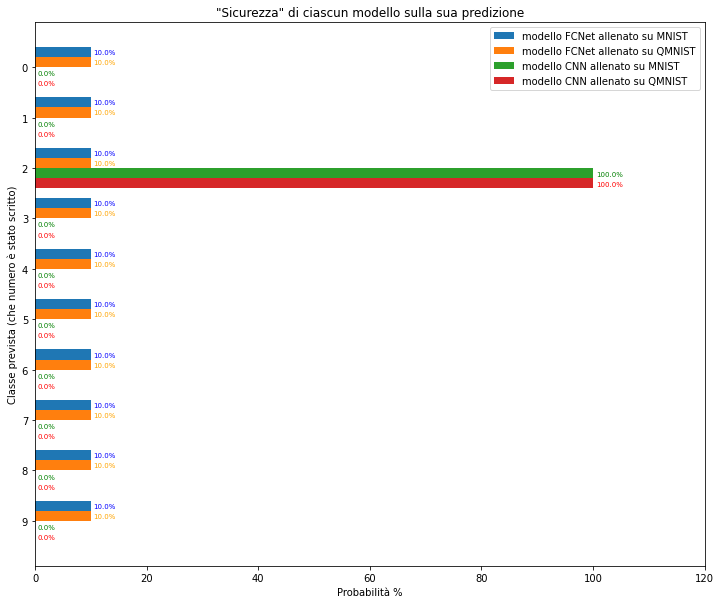

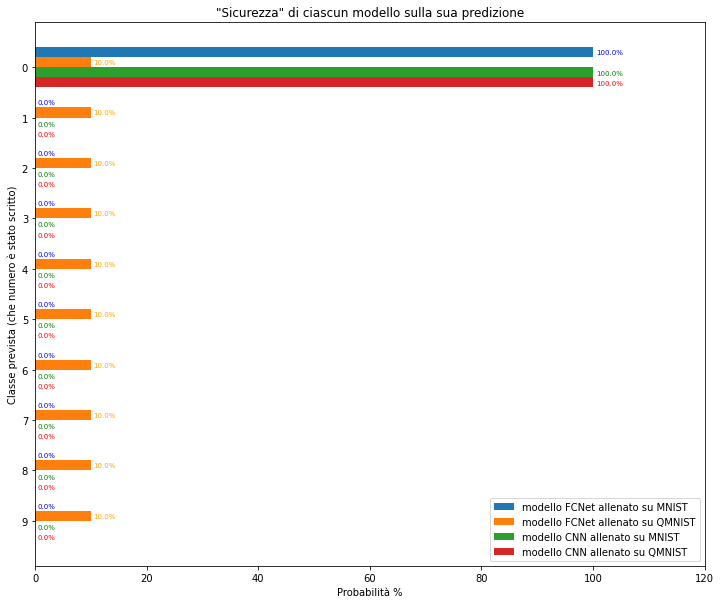

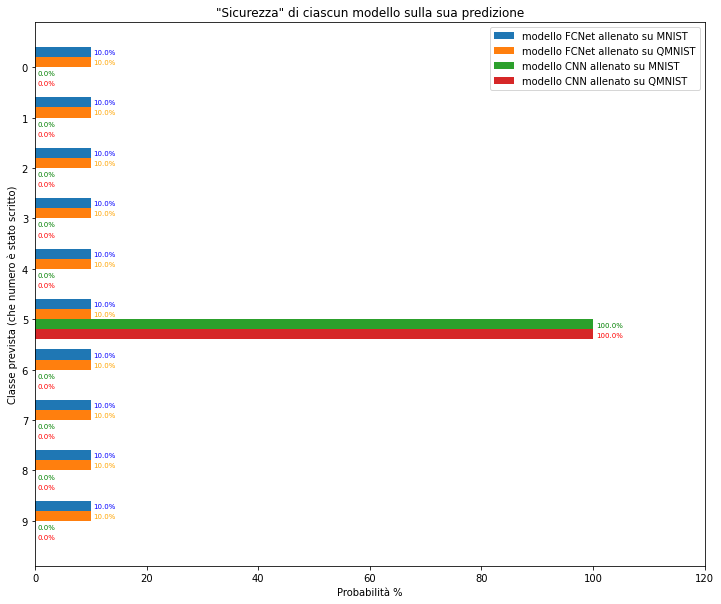

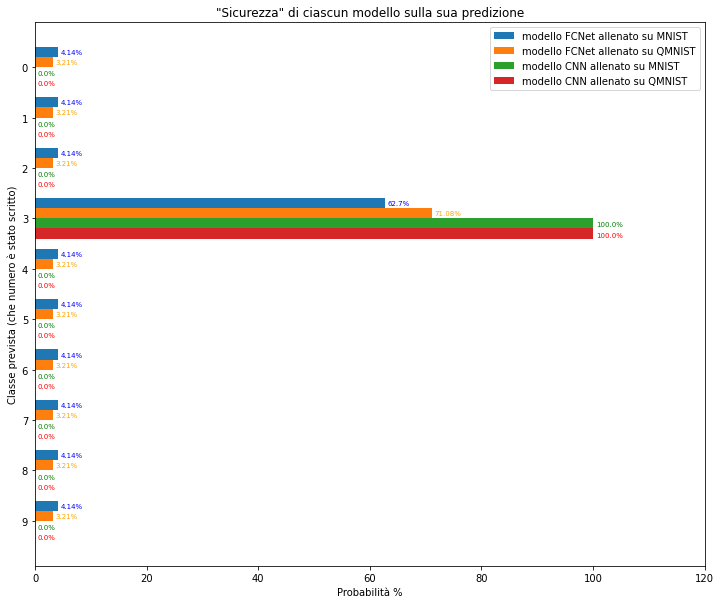

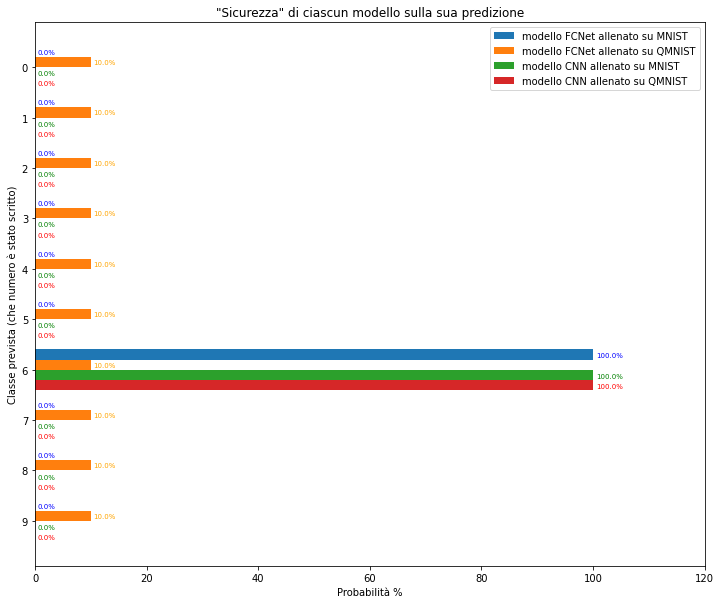

In [22]:
#Mostro i "BATCH_SIZE" grafici a barre con le probabilità per ogni classe

for i in range(BATCH_SIZE):
  classi = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9']
  y = np.arange(len(classi))  
  width = 0.2  
  fig, ax = plt.subplots(figsize=(12,10))

  #Imposto l'aspetto del grafico
  ax.barh(y - 3/2*width, prob_totale_4[i], width, label='modello FCNet allenato su MNIST')
  ax.barh(y - width/2, prob_totale_3[i], width, label='modello FCNet allenato su QMNIST')
  ax.barh(y + width/2, prob_totale_2[i], width, label='modello CNN allenato su MNIST')
  ax.barh(y + 3/2*width, prob_totale_1[i], width, label='modello CNN allenato su QMNIST')  
  
  ax.set_xlabel('Probabilità %')
  ax.set_ylabel('Classe prevista (che numero è stato scritto)')
  ax.set_title('\"Sicurezza\" di ciascun modello sulla sua predizione')
  ax.set_yticks(y)
  ax.set_yticklabels(classi)
  ax.invert_yaxis()
  ax.legend()
  plt.xlim(0, 120)

  #Aggiungo i label con le percentuali
  for j in range(len(classi)):
    ax.text(prob_totale_1[i][j]+.5, y[j] + 1.8*width,str(round(prob_totale_1[i][j],2))+"%",fontsize=7, color="red")
    ax.text(prob_totale_2[i][j]+.5, y[j] + 0.8*width,str(round(prob_totale_2[i][j],2))+"%",fontsize=7, color="green")
    ax.text(prob_totale_3[i][j]+.5, y[j] + -0.3*width,str(round(prob_totale_3[i][j],2))+"%",fontsize=7, color="orange")
    ax.text(prob_totale_4[i][j]+.5, y[j] + -1.3*width,str(round(prob_totale_4[i][j],2))+"%",fontsize=7, color="blue")
  plt.show() 